Team mate: <br>
Name.  : Breej Vania
Banner : B00843525

## [2 pts] De-noising autoencoders
Using the reconstructed images, obtained when variance = 90%, train a denoising autoencoder. Where the input to the denoising autoencoder will be the noisy images (i.e., the reconstructed images) and the output of the decoder need to be the noiseless image (original image). Use the denoised outputs of the denoising
 1
CSCI 4155/6505 – Winter 2020 A4
 auto-encoder to train the CNN and report the observations in terms of performance when compared to the performance of CNNs trained using reconstructed images with variance equal to 50%.

In [0]:
# PyTorch packages
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
# For plotting
import matplotlib.pyplot as plt

In [0]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [0]:
train_data_reshaped = train_data.data.reshape(60000,784)
test_data_reshaped = test_data.data.reshape(10000,784)
pca = PCA(n_components=0.90)
pca.fit(train_data_reshaped)
print(pca.n_components_)
# input_train_data = pca.transform(train_data_reshaped)
input_test_data = pca.transform(test_data_reshaped)
# restored_train_data = pca.inverse_transform(input_train_data)
restored_test_data = pca.inverse_transform(input_test_data)
# train_data_temp_ = torch.from_numpy(restored_train_data)
test_data_temp_ = torch.from_numpy(restored_test_data)
# train_data_final_ = train_data_temp_.reshape(-1,1,28,28)
test_data_final_ = test_data_temp_.reshape(-1,1,28,28)

87


In [0]:
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
# temp_train = torch.utils.data.TensorDataset(train_data_final_, train_data.targets)
temp_test = torch.utils.data.TensorDataset(test_data_final_, test_data.targets)
# train_loader = torch.utils.data.DataLoader(temp_train, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(temp_test, batch_size=batch_size, num_workers=num_workers)
train_loader_ = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader_ = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = torch.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [0]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
n_epochs = 5

# for adding noise to images
noise_factor=0.2

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader_:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader_)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.536375
Epoch: 2 	Training Loss: 0.491817
Epoch: 3 	Training Loss: 0.465118
Epoch: 4 	Training Loss: 0.446541
Epoch: 5 	Training Loss: 0.431346


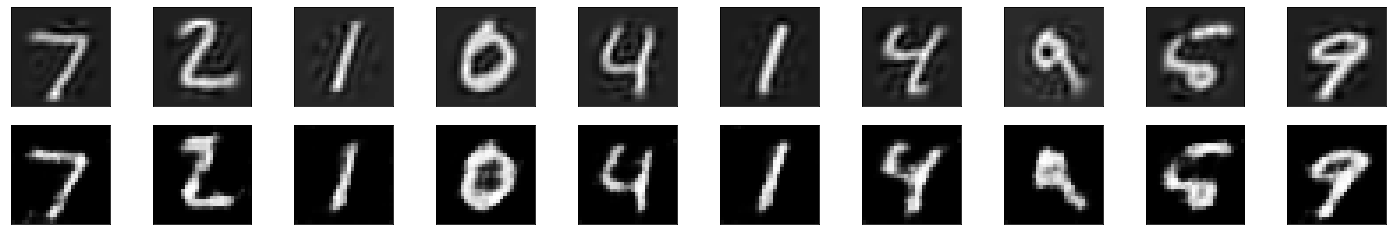

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader_)
images, labels = dataiter.next()
dataiter_2 = iter(test_loader)
images_2, labels_2 = dataiter_2.next()
# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = images_2.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


### Observations: As we can see, here the images on the top are the reconstructed ones (variance = 90%) and the images beneath them are the denoised output from our NN

In [0]:
train_data_reshaped = train_data.data.reshape(60000,784)
test_data_reshaped = test_data.data.reshape(10000,784)
pca = PCA(n_components=0.90)
pca.fit(train_data_reshaped)
print(pca.n_components_)
# input_train_data = pca.transform(train_data_reshaped)
input_test_data = pca.transform(test_data_reshaped)
# restored_train_data = pca.inverse_transform(input_train_data)
restored_test_data = pca.inverse_transform(input_test_data)
# train_data_temp_ = torch.from_numpy(restored_train_data)
test_data_temp_ = torch.from_numpy(restored_test_data)
# train_data_final_ = train_data_temp_.reshape(-1,1,28,28)
test_data_final_ = test_data_temp_.reshape(-1,1,28,28)

In [0]:
def eval_net_b(epochs, batch_size):

  ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Create iterators for each dataset ######################################
  temp_train = torch.utils.data.TensorDataset(train_data_final, train_data.targets)
  temp_test = torch.utils.data.TensorDataset(test_data_final, test_data.targets)
  train_loader = torch.utils.data.DataLoader(temp_train, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(temp_test, batch_size=batch_size, shuffle=False)
  # train_loader = torch.utils.data.DataLoader(train_data_final_re, batch_size=batch_size, shuffle=True)
  # test_loader = torch.utils.data.DataLoader(train_data_final_re, batch_size=batch_size, shuffle=False)

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
      self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in range(epochs):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients
      
      outputs = net(inputs.float()) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      inputs, labels = data
      outputs = net(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on test data ####################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      outputs = net(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc

### Training CNN for 90% and 50% variance retained images 

87
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9813
Test accuracy:  0.9823


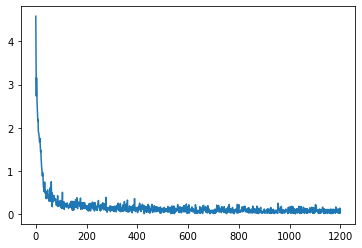

11
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9287833333333333
Test accuracy:  0.9284


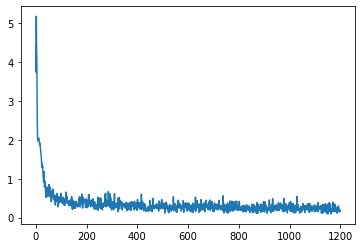

[0.9823, 0.9284]


In [0]:
variance_list=[0.90, 0.50]
test_accuracies_CNN = []
for variance in variance_list:
  pca = PCA(n_components=variance)
  pca.fit(train_data_reshaped)
  print(pca.n_components_)
  input_train_data = pca.transform(train_data_reshaped)
  input_test_data = pca.transform(test_data_reshaped)
  restored_train_data = pca.inverse_transform(input_train_data)
  restored_test_data = pca.inverse_transform(input_test_data)
  train_data_temp_ = torch.from_numpy(restored_train_data)
  test_data_temp_ = torch.from_numpy(restored_test_data)
  train_data_final_ = train_data_temp_.reshape(-1,1,28,28)
  test_data_final_ = test_data_temp_.reshape(-1,1,28,28)
  losses, train_acc, test_acc = eval_net_b(epochs=2, batch_size=100)
  print("Training accuracy: ", train_acc)
  print("Test accuracy: ", test_acc)
  test_accuracies_CNN.append(test_acc)
  plt.plot(losses)
  plt.show()
print(test_accuracies_CNN)

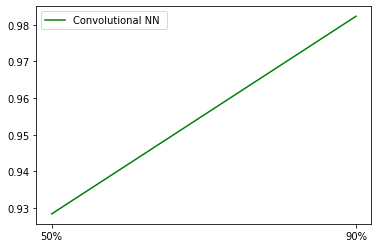

In [0]:
var_lvls = ['50%','90%']
plt.plot(sorted(test_accuracies_CNN), linestyle='-', color='g', label='Convolutional NN ')
plt.xticks([0,1], var_lvls)
plt.legend(loc='best')

### Observations: The accuracy plot for CNN with 50% and 90% variance levels
Since it has only 2 accuracy plot, it comes out as a straight line.<br>
As expected, the accuracies for 90% is relatively higher due to higher feature retention compared to 50%